In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np

import ncar_jobqueue
from dask.distributed import Client

import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 

from statistics import mean
from matplotlib import style
from scipy import stats
import pandas as pd
import sklearn

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

import utils
style.use('default')
import matplotlib.path as mpath

In [3]:
case = 'g.e22a06.G1850ECOIAF_JRA_PHYS_DEV.TL319_g17.4p4z.005'
path = '/glade/scratch/kristenk/archive/' + case + '/ocn/proc/tseries/year_1'
variables = ['photoC_TOT_zint','x_graze_zoo3_zint','x_graze_zoo4_zint',
             'photoC_diat_zint','photoC_sp_zint','photoC_cocco_zint',
             'zoo1C', 'zoo2C', 'zoo3C', 'zoo4C','zoo2_TL_zavg','zoo3_TL_zavg',
             'zoo4_TL_zavg','microzoo_TL_zavg','largezoo_TL_zavg','all_zoo_TL_zavg',
            'diatC','spC','coccoC','diazC','TEMP','SHF_QSW','IFRAC','HMXL','TAUX','TAUY']
coords = {'x':'TLONG','y':'TLAT'}
keepthese = ['z_t','time_bound','TAREA','REGION_MASK', 'time'] + variables
keep_vars = keepthese +list(coords.values())+['dz','KMT']

#### get case

In [4]:
%%time
ds_list = []
print(f'reading {case}')
ds = xr.Dataset()

for v in variables:  
    print(v)
    files = sorted(glob(f'{path}/{case}.annual.{v}.0062-0122.nc'))       
    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"])
    
    ds = xr.merge((ds, dsv))
    ds_list.append(ds)

reading g.e22a06.G1850ECOIAF_JRA_PHYS_DEV.TL319_g17.4p4z.005
photoC_TOT_zint
x_graze_zoo3_zint
x_graze_zoo4_zint
photoC_diat_zint
photoC_sp_zint
photoC_cocco_zint
zoo1C
zoo2C
zoo3C
zoo4C
zoo2_TL_zavg
zoo3_TL_zavg
zoo4_TL_zavg
microzoo_TL_zavg
largezoo_TL_zavg
all_zoo_TL_zavg
diatC
spC
coccoC
diazC
TEMP
SHF_QSW
IFRAC
HMXL
TAUX
TAUY
CPU times: user 13.2 s, sys: 2.47 s, total: 15.7 s
Wall time: 22.8 s


In [5]:
ds['zratio'] = (ds.x_graze_zoo3_zint + ds.x_graze_zoo4_zint) / ds.photoC_TOT_zint

ds['diatNPPfrac'] = (ds.photoC_diat_zint) / ds.photoC_TOT_zint

tmp = ds.zoo1C * 10.
ds['zoo1C_zint'] = tmp.sum(dim='z_t_150m')

tmp = ds.zoo2C * 10.
ds['zoo2C_zint'] = tmp.sum(dim='z_t_150m')

tmp = ds.zoo3C * 10.
ds['zoo3C_zint'] = tmp.sum(dim='z_t_150m')

tmp = ds.zoo4C * 10.
ds['zoo4C_zint'] = tmp.sum(dim='z_t_150m')

ds['HTLfood_zint'] = ds['zoo3C_zint'] + ds['zoo4C_zint']

tmp = ds.diatC * 10.
ds['diatC_zint'] = tmp.sum(dim='z_t_150m')

tmp = ds.spC * 10.
ds['spC_zint'] = tmp.sum(dim='z_t_150m')

tmp = ds.coccoC * 10.
ds['coccoC_zint'] = tmp.sum(dim='z_t_150m')

tmp = ds.diazC * 10.
ds['diazC_zint'] = tmp.sum(dim='z_t_150m')

ds['TEMP_100m'] = ds.TEMP.isel(z_t=slice(0,10)).mean(dim='z_t')

In [6]:
ds['microzoo_TL_zavg'] = microzoo_TL = (2. * ds.zoo1C_zint + ds.zoo2_TL_zavg * ds.zoo2C_zint) / (ds.zoo1C_zint + ds.zoo2C_zint)

In [7]:
ds['largezoo_TL_zavg'] = largezoo_TL = (ds.zoo3_TL_zavg * ds.zoo3C_zint + ds.zoo4_TL_zavg * ds.zoo4C_zint) / (ds.zoo3C_zint + ds.zoo4C_zint)

In [8]:
ds['all_zoo_TL_zavg'] = (2. * ds.zoo1C_zint + ds.zoo2_TL_zavg * ds.zoo2C_zint + ds.zoo3_TL_zavg * ds.zoo3C_zint + ds.zoo4_TL_zavg * ds.zoo4C_zint) / (ds.zoo1C_zint + ds.zoo2C_zint + ds.zoo3C_zint + ds.zoo4C_zint)

### drop 3d variables

In [9]:
ds = ds.drop(['diatC','spC','coccoC','diazC','TEMP','zoo1C', 'zoo2C', 'zoo3C', 'zoo4C'])

In [10]:
ds

<xarray.Dataset>
Dimensions:            (nlat: 384, nlon: 320, time: 61, z_t: 60)
Coordinates:
  * time               (time) object 0062-12-31 00:00:00 ... 0122-12-31 00:00:00
    TLAT               (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG              (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * z_t                (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
Dimensions without coordinates: nlat, nlon
Data variables: (12/32)
    KMT                (time, nlat, nlon) float64 dask.array<chunksize=(61, 384, 320), meta=np.ndarray>
    TAREA              (time, nlat, nlon) float64 dask.array<chunksize=(61, 384, 320), meta=np.ndarray>
    dz                 (time, z_t) float32 dask.array<chunksize=(61, 60), meta=np.ndarray>
    photoC_TOT_zint    (time, nlat, nlon) float32 dask.array<chunksize=(61, 384, 320), meta=np.ndarray>
    x_graze_zoo3_zint  (time, nlat, nlon) float32 dask.array<chunksize=(61, 384, 320), meta=np.ndarray>
    x_graze_zoo4_zint  (time, nlat, nlon) float32 dask.array<chunksize=(61, 384, 320), meta=np.ndarray>
    ...                 ...
    HTLfood_zint       (time, nlat, nlon) float32 dask.array<chunksize=(61, 384, 320), meta=np.ndarray>
    diatC_zint         (time, nlat, nlon) float32 dask.array<chunksize=(61, 384, 320), meta=np.ndarray>
    spC_zint           (time, nlat, nlon) float32 dask.array<chunksize=(61, 384, 320), meta=np.ndarray>
    coccoC_zint        (time, nlat, nlon) float32 dask.array<chunksize=(61, 384, 320), meta=np.ndarray>
    diazC_zint         (time, nlat, nlon) float32 dask.array<chunksize=(61, 384, 320), meta=np.ndarray>
    TEMP_100m          (time, nlat, nlon) float32 dask.array<chunksize=(61, 384, 320), meta=np.ndarray>

### update variable list

In [11]:
variables = ['zratio','HTLfood_zint','zoo4C_zint','diatC_zint','coccoC_zint','spC_zint','diazC_zint',
             'diatNPPfrac','photoC_TOT_zint','photoC_diat_zint','zoo2_TL_zavg','zoo3_TL_zavg',
             'zoo4_TL_zavg','microzoo_TL_zavg','largezoo_TL_zavg','all_zoo_TL_zavg',
             'zoo1C_zint','zoo2C_zint','zoo3C_zint','zoo4C_zint','TEMP_100m','SHF_QSW','IFRAC','HMXL','TAUX','TAUY']

### get grid and define years

In [12]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
lons=ds_grid.TLONG
lats=ds_grid.TLAT
area=ds_grid.TAREA
area_m=ds_grid.TAREA * 1.e-4
depths=ds_grid.z_t * 0.01
tlen=len(ds.time)
years = np.arange(1958,1958+tlen,1)

### detrend the dataset variables -- make anomalies

In [13]:
ds['time'] = years

In [14]:
time_3d = np.full((61,384,320),np.nan)

i = 0
for yr in years:
    time_3d[i,:,:] = yr
    i = i + 1

In [15]:
ds_anoms = xr.Dataset({v: ds[v] for v in ['time']})

In [16]:
%%time

for v in variables:
    
    print('doing variable: ',v)
    
    da = ds[v]
    model = da.polyfit("time", 1)
    
    m = model.polyfit_coefficients.sel(degree=1)
    b = model.polyfit_coefficients.sel(degree=0)
    
    predicted = m.values * time_3d + b.values
    
    ds_anoms[v] = da - predicted

doing variable:  zratio
doing variable:  HTLfood_zint
doing variable:  zoo4C_zint
doing variable:  diatC_zint
doing variable:  coccoC_zint
doing variable:  spC_zint
doing variable:  diazC_zint
doing variable:  diatNPPfrac
doing variable:  photoC_TOT_zint
doing variable:  photoC_diat_zint
doing variable:  zoo2_TL_zavg
doing variable:  zoo3_TL_zavg
doing variable:  zoo4_TL_zavg
doing variable:  microzoo_TL_zavg
doing variable:  largezoo_TL_zavg
doing variable:  all_zoo_TL_zavg
doing variable:  zoo1C_zint
doing variable:  zoo2C_zint
doing variable:  zoo3C_zint
doing variable:  zoo4C_zint
doing variable:  TEMP_100m
doing variable:  SHF_QSW
doing variable:  IFRAC
doing variable:  HMXL
doing variable:  TAUX
doing variable:  TAUY
CPU times: user 5min 10s, sys: 21 s, total: 5min 31s
Wall time: 5min 49s


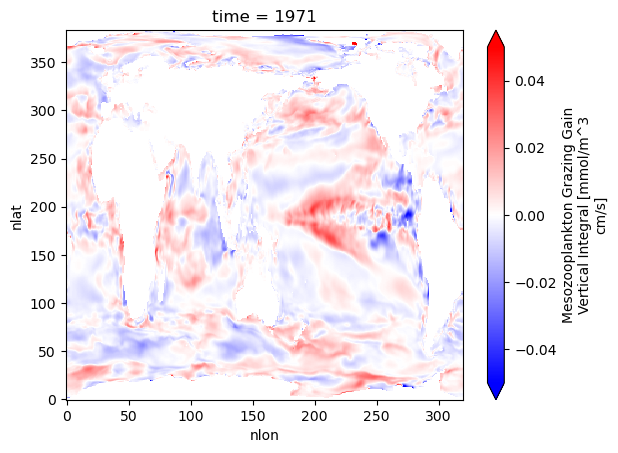

In [17]:
ds_anoms.zratio.isel(time=13).plot(vmin=-0.05,vmax=0.05,cmap='bwr')

In [18]:
years

array([1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968,
       1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979,
       1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990,
       1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014, 2015, 2016, 2017, 2018])

### Do MLR in some interesting boxes

In [19]:
## overlay on large zooplankton standard deviation map
file = '/glade/p/datashare/kristenk/zoo_stdev/zoo_stdev.nc'
ds_stdev=xr.open_dataset(file)

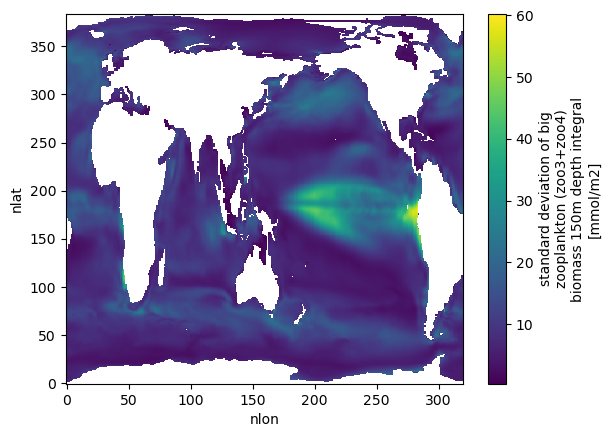

In [20]:
ds_stdev.big_zooC_zint.plot()

#### make longitudes that go from -180 to 180

In [21]:
lons_norm = utils.normal_lons(lons)

### Make timeseries for different boxes

In [22]:
#box #1, south victoria land
box1_latmin = -80.
box1_latmax = -75.
box1_lonmin = 160.
box1_lonmax = 180.

#box #2, western antarctic peninsula
box2_latmin = -65.
box2_latmax = -62.
box2_lonmin = -68.
box2_lonmax = -57.

#box #3, subantarctic part of Pacific sector with high big zoo variability
box3_latmin = -58.
box3_latmax = -50.
box3_lonmin = -120.
box3_lonmax = -100.

#box #4, Amundsen Sea
box4_latmin = -75.
box4_latmax = -70.
box4_lonmin = -120.
box4_lonmax = -100.

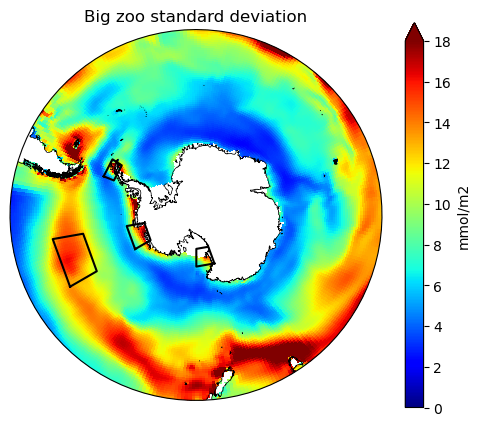

In [23]:
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_stdev.big_zooC_zint)

fig = plt.figure(figsize=(6,5))

############ make map
ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -40], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
###################### end circle
ax.set_title('Big zoo standard deviation', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=18,
                 transform=ccrs.PlateCarree())
# box1
lon_pts = [box1_lonmin,box1_lonmax,box1_lonmax,box1_lonmin,box1_lonmin]
lat_pts = [box1_latmax,box1_latmax,box1_latmin,box1_latmin,box1_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

# box2
lon_pts = [box2_lonmin,box2_lonmax,box2_lonmax,box2_lonmin,box2_lonmin]
lat_pts = [box2_latmax,box2_latmax,box2_latmin,box2_latmin,box2_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

# # box3
lon_pts = [box3_lonmin,box3_lonmax,box3_lonmax,box3_lonmin,box3_lonmin]
lat_pts = [box3_latmax,box3_latmax,box3_latmin,box3_latmin,box3_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

# # box4
lon_pts = [box4_lonmin,box4_lonmax,box4_lonmax,box4_lonmin,box4_lonmin]
lat_pts = [box4_latmax,box4_latmax,box4_latmin,box4_latmin,box4_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,label='mmol/m2', extend='max')

In [24]:
ts_box1 = xr.Dataset({v: ds_anoms[v] for v in ['time']})

for var in variables:
    print(var)
    masked = ds_anoms[var].where(lats<box1_latmax).where(lats>box1_latmin).where(lons_norm<box1_lonmax).where(lons_norm>box1_lonmin)
    ts_box1[var] = esmlab.weighted_mean(masked, weights=area_m, dim=['nlat', 'nlon']).compute()

zratio
HTLfood_zint
zoo4C_zint
diatC_zint
coccoC_zint
spC_zint
diazC_zint
diatNPPfrac
photoC_TOT_zint
photoC_diat_zint
zoo2_TL_zavg
zoo3_TL_zavg
zoo4_TL_zavg
microzoo_TL_zavg
largezoo_TL_zavg
all_zoo_TL_zavg
zoo1C_zint
zoo2C_zint
zoo3C_zint
zoo4C_zint
TEMP_100m
SHF_QSW
IFRAC
HMXL
TAUX
TAUY


In [25]:
box1_df = pd.DataFrame()
box1_df['year'] = years

for v in variables:
    box1_df[v] = ts_box1[v]
    
box1_df.head()

,year,zratio,HTLfood_zint,zoo4C_zint,diatC_zint,coccoC_zint,spC_zint,diazC_zint,diatNPPfrac,photoC_TOT_zint,...,all_zoo_TL_zavg,zoo1C_zint,zoo2C_zint,zoo3C_zint,TEMP_100m,SHF_QSW,IFRAC,HMXL,TAUX,TAUY
0,1958,0.001686,-0.433347,-0.014362,-0.606656,-0.000758,-2.797308,-0.000016,0.002161,-0.001447,...,0.005197,4.334025,0.780162,-0.418985,0.028947,-4.307383,0.003104,13.330383,-0.045741,-0.074343
1,1959,-0.007769,-2.840919,-0.297261,10.548772,-0.000660,5.007787,-0.000018,-0.007648,0.006523,...,0.000214,6.308752,0.473104,-2.543658,-0.046018,0.921222,-0.002343,665.571328,-0.009710,-0.010924
2,1960,-0.000030,-0.763289,-0.110597,3.503665,-0.000740,0.510116,-0.000015,0.004565,0.000520,...,-0.002858,3.597670,0.354554,-0.652693,0.031634,3.140857,-0.009061,718.114163,0.018022,0.027744
3,1961,0.004419,3.080919,0.512443,4.170201,-0.000858,-2.943883,-0.000010,0.060930,-0.000969,...,0.001246,-2.864301,0.257114,2.568477,0.024093,-0.946661,-0.005173,-438.172783,-0.010875,-0.036785
4,1962,0.003625,1.078629,0.606732,-10.328813,-0.000763,-2.303069,-0.000006,-0.072643,-0.003357,...,0.013345,-5.804897,-0.154437,0.471897,-0.047872,-2.640802,0.022020,-301.846957,-0.005224,-0.078113


In [26]:
ts_box2 = xr.Dataset({v: ds_anoms[v] for v in ['time']})

for var in variables:
    print(var)
    masked = ds_anoms[var].where(lats<box2_latmax).where(lats>box2_latmin).where(lons_norm<box2_lonmax).where(lons_norm>box2_lonmin)
    ts_box2[var] = esmlab.weighted_mean(masked, weights=area_m, dim=['nlat', 'nlon']).compute()

zratio
HTLfood_zint
zoo4C_zint
diatC_zint
coccoC_zint
spC_zint
diazC_zint
diatNPPfrac
photoC_TOT_zint
photoC_diat_zint
zoo2_TL_zavg
zoo3_TL_zavg
zoo4_TL_zavg
microzoo_TL_zavg
largezoo_TL_zavg
all_zoo_TL_zavg
zoo1C_zint
zoo2C_zint
zoo3C_zint
zoo4C_zint
TEMP_100m
SHF_QSW
IFRAC
HMXL
TAUX
TAUY


In [27]:
box2_df = pd.DataFrame()
box2_df['year'] = years

for v in variables:
    box2_df[v] = ts_box2[v]
    
box2_df.head()

,year,zratio,HTLfood_zint,zoo4C_zint,diatC_zint,coccoC_zint,spC_zint,diazC_zint,diatNPPfrac,photoC_TOT_zint,...,all_zoo_TL_zavg,zoo1C_zint,zoo2C_zint,zoo3C_zint,TEMP_100m,SHF_QSW,IFRAC,HMXL,TAUX,TAUY
0,1958,0.001214,-4.607135,-1.545500,-8.634823,-0.049440,-1.597988,-0.000099,-0.002622,-0.001464,...,-0.003084,-0.585182,-0.516495,-3.061635,-0.012129,-1.750971,0.060523,-458.212402,0.065127,0.012357
1,1959,-0.004133,-6.687189,-1.165065,-2.972443,-0.091932,-1.943331,-0.000070,0.003154,-0.000533,...,0.000089,-1.509322,-0.511695,-5.522124,-0.106203,-4.499812,0.057170,-27.961125,0.114378,0.080512
2,1960,-0.004550,-6.379405,-1.147347,12.923560,-0.103874,1.486861,-0.000008,0.005980,0.001583,...,-0.004142,0.341056,-0.714640,-5.232057,-0.026180,5.316567,-0.062141,-7.679283,0.127409,-0.102427
3,1961,0.003054,0.782543,0.733295,-10.314297,0.014785,-0.670099,0.000013,-0.001111,-0.002161,...,0.007830,-0.089782,0.567625,0.049248,0.006896,-4.473083,0.032439,394.424926,-0.122068,0.061432
4,1962,0.001177,2.048790,0.037322,9.048898,-0.092323,0.696444,0.000004,0.002932,0.001587,...,-0.003646,1.005640,-0.345046,2.011469,-0.028446,6.048142,-0.077503,152.800216,0.039251,-0.060541


In [28]:
ts_box3 = xr.Dataset({v: ds_anoms[v] for v in ['time']})

for var in variables:
    print(var)
    masked = ds_anoms[var].where(lats<box3_latmax).where(lats>box3_latmin).where(lons_norm<box3_lonmax).where(lons_norm>box3_lonmin)
    ts_box3[var] = esmlab.weighted_mean(masked, weights=area_m, dim=['nlat', 'nlon']).compute()

zratio
HTLfood_zint
zoo4C_zint
diatC_zint
coccoC_zint
spC_zint
diazC_zint
diatNPPfrac
photoC_TOT_zint
photoC_diat_zint
zoo2_TL_zavg
zoo3_TL_zavg
zoo4_TL_zavg
microzoo_TL_zavg
largezoo_TL_zavg
all_zoo_TL_zavg
zoo1C_zint
zoo2C_zint
zoo3C_zint
zoo4C_zint
TEMP_100m
SHF_QSW
IFRAC
HMXL
TAUX
TAUY


In [29]:
box3_df = pd.DataFrame()
box3_df['year'] = years

for v in variables:
    box3_df[v] = ts_box3[v]
    
box3_df.head()

,year,zratio,HTLfood_zint,zoo4C_zint,diatC_zint,coccoC_zint,spC_zint,diazC_zint,diatNPPfrac,photoC_TOT_zint,...,all_zoo_TL_zavg,zoo1C_zint,zoo2C_zint,zoo3C_zint,TEMP_100m,SHF_QSW,IFRAC,HMXL,TAUX,TAUY
0,1958,0.004634,14.296893,6.222030,-7.505193,-1.135143,2.002872,-0.000120,-0.004509,-0.000426,...,-0.007295,1.015743,-1.351866,8.074863,0.271924,-1.390593,0.0,-121.521740,-0.087033,-0.123878
1,1959,0.008339,10.596565,2.769966,21.187969,-0.681740,-0.290795,-0.000179,0.042568,0.002792,...,-0.009593,-0.140494,-1.960636,7.826600,0.218365,-0.094929,0.0,284.557886,-0.009807,-0.010064
2,1960,-0.009351,-0.951595,-0.242416,-2.529395,1.432605,0.680781,-0.000198,-0.020904,-0.000095,...,-0.006204,0.679793,-4.177583,-0.709179,0.015828,2.981665,0.0,3557.242975,0.276574,0.060828
3,1961,0.005251,0.523531,-1.153383,16.825372,-0.494337,-0.121165,-0.000296,0.045558,0.001778,...,-0.010228,-0.275539,-3.118473,1.676914,-0.087299,-0.816141,0.0,50.642985,0.218627,-0.122419
4,1962,0.007032,10.801848,1.306531,4.962682,-0.289286,-3.073287,-0.000282,0.013984,-0.000401,...,-0.008907,0.928885,-3.645283,9.495317,-0.070881,1.443062,0.0,772.526248,-0.108618,0.034979


In [30]:
ts_box4 = xr.Dataset({v: ds_anoms[v] for v in ['time']})

for var in variables:
    print(var)
    masked = ds_anoms[var].where(lats<box4_latmax).where(lats>box4_latmin).where(lons_norm<box4_lonmax).where(lons_norm>box4_lonmin)
    ts_box4[var] = esmlab.weighted_mean(masked, weights=area_m, dim=['nlat', 'nlon']).compute()

zratio
HTLfood_zint
zoo4C_zint
diatC_zint
coccoC_zint
spC_zint
diazC_zint
diatNPPfrac
photoC_TOT_zint
photoC_diat_zint
zoo2_TL_zavg
zoo3_TL_zavg
zoo4_TL_zavg
microzoo_TL_zavg
largezoo_TL_zavg
all_zoo_TL_zavg
zoo1C_zint
zoo2C_zint
zoo3C_zint
zoo4C_zint
TEMP_100m
SHF_QSW
IFRAC
HMXL
TAUX
TAUY


In [31]:
box4_df = pd.DataFrame()
box4_df['year'] = years

for v in variables:
    box4_df[v] = ts_box4[v]
    
box4_df.head()

,year,zratio,HTLfood_zint,zoo4C_zint,diatC_zint,coccoC_zint,spC_zint,diazC_zint,diatNPPfrac,photoC_TOT_zint,...,all_zoo_TL_zavg,zoo1C_zint,zoo2C_zint,zoo3C_zint,TEMP_100m,SHF_QSW,IFRAC,HMXL,TAUX,TAUY
0,1958,-0.015235,-8.554778,-1.958734,-6.113560,-0.004290,3.593332,-0.000082,-0.095506,0.001244,...,-0.010744,3.281987,-0.638332,-6.596044,-0.067776,2.348858,0.007775,-233.471712,-0.005020,0.078981
1,1959,-0.006385,-4.005401,-0.891671,15.228506,-0.004018,-5.104661,-0.000054,0.123994,0.000617,...,0.055734,3.594837,2.328475,-3.113730,0.061247,-2.101928,-0.005545,-302.617883,0.104576,-0.063511
2,1960,0.014595,-0.842288,-0.308865,-12.493737,0.002028,0.330394,-0.000013,-0.042277,-0.003065,...,0.074651,-6.475735,-1.405584,-0.533423,-0.027394,-6.189528,0.004207,109.515984,-0.007469,0.006806
3,1961,-0.016700,-12.430743,-1.944976,2.706403,-0.002987,-0.885017,0.000006,0.042555,0.000179,...,0.048888,3.503518,0.798629,-10.485767,-0.114414,-8.083041,0.063654,-76.520600,-0.234507,-0.046714
4,1962,0.004367,2.503222,-0.144955,-7.739764,0.005705,5.111699,-0.000007,-0.111764,0.000342,...,-0.010315,1.840007,-0.526071,2.648176,0.034456,2.575917,-0.025026,-144.711674,0.072069,-0.163045


### visualize NPP & z-ratio correlation in each box

In [32]:
big_zoo_corrs = xr.Dataset()

for var in ['SHF_QSW','IFRAC','HMXL','photoC_TOT_zint','photoC_diat_zint','diatC_zint','TEMP_100m']:
    print(var)
    big_zoo_corrs[var] = xr.corr(ds_anoms.HTLfood_zint, ds_anoms[var], dim='time').squeeze()


SHF_QSW
IFRAC
HMXL
photoC_TOT_zint
photoC_diat_zint
diatC_zint
TEMP_100m


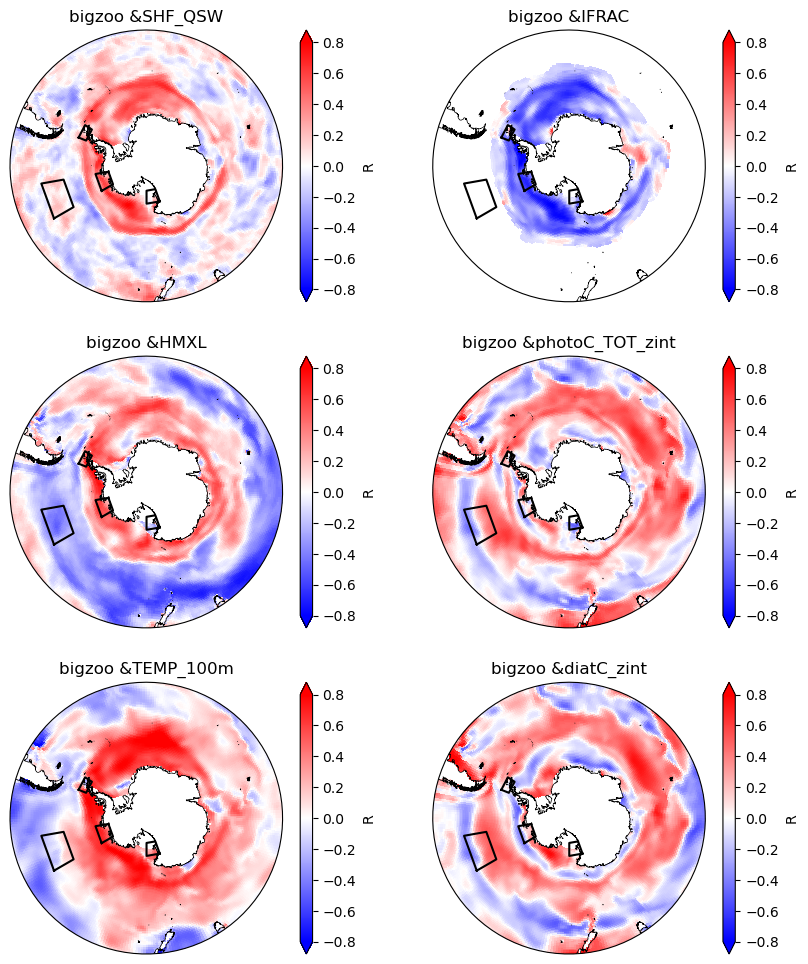

In [33]:
corrs = []

fig = plt.figure(figsize=(10,12))
i=0
for var in ['SHF_QSW','IFRAC','HMXL','photoC_TOT_zint','TEMP_100m','diatC_zint']:
    
    i= i + 1
    
    lon, lat, field = utils.adjust_pop_grid(lons, lats, big_zoo_corrs[var])
    
    ############ make map
    ax = fig.add_subplot(3,2,i, projection=ccrs.SouthPolarStereo())
    ax.set_extent([-180, 180, -90, -40], ccrs.PlateCarree())

    #################### make it a circle
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax.set_boundary(circle, transform=ax.transAxes)
    ###################### end circle
    ax.set_title('bigzoo &' + var, fontsize=12)
    ax.coastlines('10m',linewidth=0.5)
    pc=ax.pcolormesh(lon, lat, field, cmap='bwr',vmin=-0.8,vmax=0.8,
                     transform=ccrs.PlateCarree())
    # box1
    lon_pts = [box1_lonmin,box1_lonmax,box1_lonmax,box1_lonmin,box1_lonmin]
    lat_pts = [box1_latmax,box1_latmax,box1_latmin,box1_latmin,box1_latmax]
    ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

    # box2
    lon_pts = [box2_lonmin,box2_lonmax,box2_lonmax,box2_lonmin,box2_lonmin]
    lat_pts = [box2_latmax,box2_latmax,box2_latmin,box2_latmin,box2_latmax]
    ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

    # # box3
    lon_pts = [box3_lonmin,box3_lonmax,box3_lonmax,box3_lonmin,box3_lonmin]
    lat_pts = [box3_latmax,box3_latmax,box3_latmin,box3_latmin,box3_latmax]
    ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

    # # box4
    lon_pts = [box4_lonmin,box4_lonmax,box4_lonmax,box4_lonmin,box4_lonmin]
    lat_pts = [box4_latmax,box4_latmax,box4_latmin,box4_latmin,box4_latmax]
    ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

    cbar1 = fig.colorbar(pc, ax=ax,label='R', extend='both')

### List of variables available for MLR

In [34]:
box1_df.columns

Index(['year', 'zratio', 'HTLfood_zint', 'zoo4C_zint', 'diatC_zint',
       'coccoC_zint', 'spC_zint', 'diazC_zint', 'diatNPPfrac',
       'photoC_TOT_zint', 'photoC_diat_zint', 'zoo2_TL_zavg', 'zoo3_TL_zavg',
       'zoo4_TL_zavg', 'microzoo_TL_zavg', 'largezoo_TL_zavg',
       'all_zoo_TL_zavg', 'zoo1C_zint', 'zoo2C_zint', 'zoo3C_zint',
       'TEMP_100m', 'SHF_QSW', 'IFRAC', 'HMXL', 'TAUX', 'TAUY'],
      dtype='object')

# is big zoo biomass a function of NPP in any of our regions?

### HTL food as a function of NPP

In [35]:
x = box1_df[['photoC_TOT_zint']]
y = box1_df['HTLfood_zint']
x = sm.add_constant(x)
est = sm.OLS(y, x).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           HTLfood_zint   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.254
Method:                 Least Squares   F-statistic:                     21.44
Date:                Wed, 27 Oct 2021   Prob (F-statistic):           2.06e-05
Time:                        08:29:12   Log-Likelihood:                -175.20
No. Observations:                  61   AIC:                             354.4
Df Residuals:                      59   BIC:                             358.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1.398e-14      0.557   2.51e-14      1.000      -1.114       1.114
photoC_TOT_zint -1062.9472    229.572     -4.630      0.000   -1522.320    -603.574
==============================================================================
Omnibus:                        3.544   Durbin-Watson:                   0.786
Prob(Omnibus):                  0.170   Jarque-Bera (JB):                3.234
Skew:                           0.562   Prob(JB):                        0.198
Kurtosis:                       2.905   Cond. No.                         412.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
x = box2_df[['photoC_TOT_zint']]
y = box2_df['HTLfood_zint']
x = sm.add_constant(x)
est = sm.OLS(y, x).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           HTLfood_zint   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.017
Method:                 Least Squares   F-statistic:                   0.01448
Date:                Wed, 27 Oct 2021   Prob (F-statistic):              0.905
Time:                        08:29:12   Log-Likelihood:                -187.25
No. Observations:                  61   AIC:                             378.5
Df Residuals:                      59   BIC:                             382.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -8.077e-15      0.678  -1.19e-14      1.000      -1.357       1.357
photoC_TOT_zint   -35.8644    298.086     -0.120      0.905    -632.333     560.604
==============================================================================
Omnibus:                        2.063   Durbin-Watson:                   1.199
Prob(Omnibus):                  0.356   Jarque-Bera (JB):                1.278
Skew:                           0.222   Prob(JB):                        0.528
Kurtosis:                       3.553   Cond. No.                         439.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
x = box3_df[['photoC_TOT_zint']]
y = box3_df['HTLfood_zint']
x = sm.add_constant(x)
est = sm.OLS(y, x).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           HTLfood_zint   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.186
Date:                Wed, 27 Oct 2021   Prob (F-statistic):              0.280
Time:                        08:29:12   Log-Likelihood:                -239.25
No. Observations:                  61   AIC:                             482.5
Df Residuals:                      59   BIC:                             486.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             6.94e-14      1.591   4.36e-14      1.000      -3.184       3.184
photoC_TOT_zint  1248.5554   1146.248      1.089      0.280   -1045.082    3542.193
==============================================================================
Omnibus:                        0.686   Durbin-Watson:                   2.456
Prob(Omnibus):                  0.710   Jarque-Bera (JB):                0.797
Skew:                           0.217   Prob(JB):                        0.671
Kurtosis:                       2.647   Cond. No.                         720.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
x = box4_df[['photoC_TOT_zint']]
y = box4_df['HTLfood_zint']
x = sm.add_constant(x)
est = sm.OLS(y, x).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           HTLfood_zint   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.016
Method:                 Least Squares   F-statistic:                   0.04075
Date:                Wed, 27 Oct 2021   Prob (F-statistic):              0.841
Time:                        08:29:12   Log-Likelihood:                -212.72
No. Observations:                  61   AIC:                             429.4
Df Residuals:                      59   BIC:                             433.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -5.876e-16      1.030  -5.71e-16      1.000      -2.061       2.061
photoC_TOT_zint  -107.9295    534.664     -0.202      0.841   -1177.790     961.931
==============================================================================
Omnibus:                        2.834   Durbin-Watson:                   1.269
Prob(Omnibus):                  0.242   Jarque-Bera (JB):                1.698
Skew:                           0.132   Prob(JB):                        0.428
Kurtosis:                       2.226   Cond. No.                         519.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### HTL food as a function of phytoplankton carbon pools

In [39]:
x = box1_df[['diatC_zint','coccoC_zint','spC_zint']] #,'diazC_zint']]
y = box1_df['HTLfood_zint']
x = sm.add_constant(x)
est = sm.OLS(y, x).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           HTLfood_zint   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.146
Method:                 Least Squares   F-statistic:                     4.420
Date:                Wed, 27 Oct 2021   Prob (F-statistic):            0.00730
Time:                        08:29:12   Log-Likelihood:                -178.28
No. Observations:                  61   AIC:                             364.6
Df Residuals:                      57   BIC:                             373.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.939e-14      0.596   3.26e-14      1.000      -1.193       1.193
diatC_zint     -0.1280      0.079     -1.619      0.111      -0.286       0.030
coccoC_zint  -718.8979    979.167     -0.734      0.466   -2679.646    1241.850
spC_zint       -0.5198      0.151     -3.438      0.001      -0.823      -0.217
==============================================================================
Omnibus:                        5.324   Durbin-Watson:                   1.156
Prob(Omnibus):                  0.070   Jarque-Bera (JB):                4.357
Skew:                           0.553   Prob(JB):                        0.113
Kurtosis:                       3.701   Cond. No.                     1.67e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.67e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [40]:
x = box2_df[['diatC_zint','coccoC_zint','spC_zint']] #,'diazC_zint']]
y = box2_df['HTLfood_zint']
x = sm.add_constant(x)
est = sm.OLS(y, x).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           HTLfood_zint   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     2.866
Date:                Wed, 27 Oct 2021   Prob (F-statistic):             0.0445
Time:                        08:29:12   Log-Likelihood:                -182.97
No. Observations:                  61   AIC:                             373.9
Df Residuals:                      57   BIC:                             382.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.118e-14      0.643  -1.74e-14      1.000      -1.288       1.288
diatC_zint     -0.0424      0.059     -0.724      0.472      -0.160       0.075
coccoC_zint     2.9242      6.047      0.484      0.631      -9.185      15.033
spC_zint        0.5797      0.434      1.334      0.187      -0.290       1.450
==============================================================================
Omnibus:                        1.743   Durbin-Watson:                   1.177
Prob(Omnibus):                  0.418   Jarque-Bera (JB):                1.018
Skew:                          -0.114   Prob(JB):                        0.601
Kurtosis:                       3.590   Cond. No.                         135.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [41]:
x = box3_df[['diatC_zint','coccoC_zint','spC_zint']] #,'diazC_zint']]
y = box3_df['HTLfood_zint']
x = sm.add_constant(x)
est = sm.OLS(y, x).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           HTLfood_zint   R-squared:                       0.570
Model:                            OLS   Adj. R-squared:                  0.548
Method:                 Least Squares   F-statistic:                     25.21
Date:                Wed, 27 Oct 2021   Prob (F-statistic):           1.65e-10
Time:                        08:29:12   Log-Likelihood:                -214.10
No. Observations:                  61   AIC:                             436.2
Df Residuals:                      57   BIC:                             444.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.148e-13      1.072   1.07e-13      1.000      -2.146       2.146
diatC_zint      0.1448      0.096      1.502      0.139      -0.048       0.338
coccoC_zint    -7.8552      1.449     -5.422      0.000     -10.756      -4.954
spC_zint       -2.7320      0.694     -3.935      0.000      -4.122      -1.342
==============================================================================
Omnibus:                        0.212   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.899   Jarque-Bera (JB):                0.362
Skew:                          -0.118   Prob(JB):                        0.834
Kurtosis:                       2.706   Cond. No.                         18.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [42]:
x = box4_df[['diatC_zint','coccoC_zint','spC_zint']] #,'diazC_zint']]
y = box4_df['HTLfood_zint']
x = sm.add_constant(x)
est = sm.OLS(y, x).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           HTLfood_zint   R-squared:                       0.245
Model:                            OLS   Adj. R-squared:                  0.205
Method:                 Least Squares   F-statistic:                     6.164
Date:                Wed, 27 Oct 2021   Prob (F-statistic):            0.00106
Time:                        08:29:12   Log-Likelihood:                -204.17
No. Observations:                  61   AIC:                             416.3
Df Residuals:                      57   BIC:                             424.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -6.431e-16      0.911  -7.06e-16      1.000      -1.824       1.824
diatC_zint      0.1444      0.110      1.307      0.196      -0.077       0.366
coccoC_zint   607.3382    152.251      3.989      0.000     302.460     912.216
spC_zint        0.6267      0.341      1.838      0.071      -0.056       1.309
==============================================================================
Omnibus:                        3.377   Durbin-Watson:                   1.345
Prob(Omnibus):                  0.185   Jarque-Bera (JB):                3.004
Skew:                           0.543   Prob(JB):                        0.223
Kurtosis:                       2.952   Cond. No.                     1.48e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.48e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### what if we add in temperature to phyto community composition?

In [43]:
x = box1_df[['diatC_zint','spC_zint','TEMP_100m']] #,'diazC_zint']]
y = box1_df['HTLfood_zint']
x = sm.add_constant(x)
est = sm.OLS(y, x).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           HTLfood_zint   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     7.554
Date:                Wed, 27 Oct 2021   Prob (F-statistic):           0.000244
Time:                        08:29:12   Log-Likelihood:                -174.45
No. Observations:                  61   AIC:                             356.9
Df Residuals:                      57   BIC:                             365.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.705e-14      0.560   8.41e-14      1.000      -1.120       1.120
diatC_zint    -0.1243      0.074     -1.675      0.099      -0.273       0.024
spC_zint      -0.5197      0.142     -3.667      0.001      -0.803      -0.236
TEMP_100m     40.9043     14.251      2.870      0.006      12.368      69.441
==============================================================================
Omnibus:                        3.937   Durbin-Watson:                   1.266
Prob(Omnibus):                  0.140   Jarque-Bera (JB):                3.022
Skew:                           0.413   Prob(JB):                        0.221
Kurtosis:                       3.713   Cond. No.                         259.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [44]:
x = box2_df[['diatC_zint','spC_zint','TEMP_100m']] #,'diazC_zint']]
y = box2_df['HTLfood_zint']
x = sm.add_constant(x)
est = sm.OLS(y, x).fit()
est.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           HTLfood_zint   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     3.535
Date:                Wed, 27 Oct 2021   Prob (F-statistic):             0.0203
Time:                        08:29:12   Log-Likelihood:                -182.05
No. Observations:                  61   AIC:                             372.1
Df Residuals:                      57   BIC:                             380.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.073e-14      0.634  -1.69e-14      1.000      -1.269       1.269
diatC_zint    -0.0728      0.046     -1.584      0.119      -0.165       0.019
spC_zint       1.1680      0.399      2.926      0.005       0.369       1.967
TEMP_100m     -6.9652      4.943     -1.409      0.164     -16.864       2.934
==============================================================================
Omnibus:                        1.861   Durbin-Watson:                   1.318
Prob(Omnibus):                  0.394   Jarque-Bera (JB):                1.162
Skew:                          -0.059   Prob(JB):                        0.559
Kurtosis:                       3.666   Cond. No.                         112.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [45]:
x = box3_df[['diatC_zint','coccoC_zint','spC_zint','TEMP_100m']] #,'diazC_zint']]
y = box3_df['HTLfood_zint']
x = sm.add_constant(x)
est = sm.OLS(y, x).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           HTLfood_zint   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.546
Method:                 Least Squares   F-statistic:                     19.06
Date:                Wed, 27 Oct 2021   Prob (F-statistic):           6.12e-10
Time:                        08:29:12   Log-Likelihood:                -213.65
No. Observations:                  61   AIC:                             437.3
Df Residuals:                      56   BIC:                             447.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.203e-13      1.073   1.12e-13      1.000      -2.150       2.150
diatC_zint      0.1430      0.097      1.481      0.144      -0.050       0.336
coccoC_zint    -8.2479      1.514     -5.449      0.000     -11.280      -5.215
spC_zint       -2.5732      0.717     -3.589      0.001      -4.009      -1.137
TEMP_100m      -4.1893      4.604     -0.910      0.367     -13.413       5.034
==============================================================================
Omnibus:                        0.237   Durbin-Watson:                   2.053
Prob(Omnibus):                  0.888   Jarque-Bera (JB):                0.395
Skew:                          -0.121   Prob(JB):                        0.821
Kurtosis:                       2.689   Cond. No.                         56.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [46]:
x = box4_df[['diatC_zint','spC_zint','TEMP_100m']] #,'diazC_zint']]
y = box4_df['HTLfood_zint']
x = sm.add_constant(x)
est = sm.OLS(y, x).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           HTLfood_zint   R-squared:                       0.491
Model:                            OLS   Adj. R-squared:                  0.464
Method:                 Least Squares   F-statistic:                     18.34
Date:                Wed, 27 Oct 2021   Prob (F-statistic):           1.89e-08
Time:                        08:29:12   Log-Likelihood:                -192.14
No. Observations:                  61   AIC:                             392.3
Df Residuals:                      57   BIC:                             400.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6.431e-16      0.748   -8.6e-16      1.000      -1.497       1.497
diatC_zint    -0.1777      0.091     -1.945      0.057      -0.361       0.005
spC_zint       0.1991      0.283      0.703      0.485      -0.368       0.767
TEMP_100m     88.7732     12.407      7.155      0.000      63.928     113.618
==============================================================================
Omnibus:                        3.108   Durbin-Watson:                   0.927
Prob(Omnibus):                  0.211   Jarque-Bera (JB):                2.331
Skew:                           0.458   Prob(JB):                        0.312
Kurtosis:                       3.280   Cond. No.                         147.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### HTL food as a function physical variables

In [80]:
x = box1_df[['TEMP_100m','TAUY']] #,'HMXL'
y = box1_df['HTLfood_zint']
x = sm.add_constant(x)
est = sm.OLS(y, x).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           HTLfood_zint   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.194
Method:                 Least Squares   F-statistic:                     8.237
Date:                Wed, 27 Oct 2021   Prob (F-statistic):           0.000710
Time:                        09:20:29   Log-Likelihood:                -177.03
No. Observations:                  61   AIC:                             360.1
Df Residuals:                      58   BIC:                             366.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.398e-14      0.579   2.42e-14      1.000      -1.158       1.158
TEMP_100m     42.9776     14.741      2.916      0.005      13.470      72.485
TAUY          20.7164      7.148      2.898      0.005       6.407      35.025
==============================================================================
Omnibus:                        0.211   Durbin-Watson:                   1.303
Prob(Omnibus):                  0.900   Jarque-Bera (JB):                0.203
Skew:                           0.125   Prob(JB):                        0.904
Kurtosis:                       2.869   Cond. No.                         25.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [81]:
x = box2_df[['TAUX','HMXL']] #'IFRAC','SHF_QSW','TEMP_100m',
y = box2_df['HTLfood_zint']
x = sm.add_constant(x)
est = sm.OLS(y, x).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           HTLfood_zint   R-squared:                       0.462
Model:                            OLS   Adj. R-squared:                  0.443
Method:                 Least Squares   F-statistic:                     24.87
Date:                Wed, 27 Oct 2021   Prob (F-statistic):           1.58e-08
Time:                        09:20:32   Log-Likelihood:                -168.37
No. Observations:                  61   AIC:                             342.7
Df Residuals:                      58   BIC:                             349.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.227e-15      0.502  -6.43e-15      1.000      -1.005       1.005
TAUX         -18.7663      3.390     -5.536      0.000     -25.552     -11.981
HMXL           0.0052      0.001      3.806      0.000       0.002       0.008
==============================================================================
Omnibus:                        0.223   Durbin-Watson:                   1.528
Prob(Omnibus):                  0.895   Jarque-Bera (JB):                0.403
Skew:                           0.098   Prob(JB):                        0.818
Kurtosis:                       2.653   Cond. No.                     2.48e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.48e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [76]:
x = box3_df[['TAUX','TEMP_100m','HMXL']] #'TAUY','SHF_QSW',
y = box3_df['HTLfood_zint']
x = sm.add_constant(x)
est = sm.OLS(y, x).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           HTLfood_zint   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.219
Method:                 Least Squares   F-statistic:                     6.599
Date:                Wed, 27 Oct 2021   Prob (F-statistic):           0.000662
Time:                        09:19:45   Log-Likelihood:                -230.77
No. Observations:                  61   AIC:                             469.5
Df Residuals:                      57   BIC:                             478.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.222e-13      1.409   8.67e-14      1.000      -2.821       2.821
TAUX         -12.8483      9.014     -1.425      0.159     -30.898       5.201
TEMP_100m    -18.0352      6.538     -2.759      0.008     -31.127      -4.944
HMXL          -0.0033      0.002     -2.105      0.040      -0.006      -0.000
==============================================================================
Omnibus:                        1.820   Durbin-Watson:                   1.782
Prob(Omnibus):                  0.402   Jarque-Bera (JB):                1.268
Skew:                           0.062   Prob(JB):                        0.530
Kurtosis:                       2.304   Cond. No.                     8.98e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.98e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [83]:
x = box4_df[['TEMP_100m','HMXL']] #,'TAUX','TAUY','SHF_QSW','IFRAC']]
y = box4_df['HTLfood_zint']
x = sm.add_constant(x)
est = sm.OLS(y, x).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           HTLfood_zint   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.550
Method:                 Least Squares   F-statistic:                     37.65
Date:                Wed, 27 Oct 2021   Prob (F-statistic):           3.30e-11
Time:                        09:25:50   Log-Likelihood:                -187.36
No. Observations:                  61   AIC:                             380.7
Df Residuals:                      58   BIC:                             387.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.212e-14      0.685   4.69e-14      1.000      -1.372       1.372
TEMP_100m     68.5224     11.360      6.032      0.000      45.782      91.262
HMXL           0.0064      0.002      4.040      0.000       0.003       0.009
==============================================================================
Omnibus:                        8.955   Durbin-Watson:                   1.194
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                8.845
Skew:                           0.717   Prob(JB):                       0.0120
Kurtosis:                       4.193   Cond. No.                     7.61e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.61e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""